In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
from glob import glob
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import warnings
import datetime
from datetime import date
from scipy import stats
import exptdata
import matplotlib
import cftime
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '025deg_abs', '01deg']


In [3]:
session = cc.database.create_session()

In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
# for plot
land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)

font = { 'family' : 'normal',
         'weight' : 'bold',
         'size'   : 16 }
matplotlib.rc('font', **font)

In [6]:
WBC=OrderedDict([
    #('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    #'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [7]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## Gulf Stream transport

### Gulf stream transport at 75W

In [25]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
gs_trans = cc.querying.getvar(expt,'tx_trans_int_z',session,
                               n=n,offset=offset)\
                               .sel(xu_ocean=-75,method='nearest')\
                               .sel(yt_ocean=slice(32,35.5))/1e6/1036

Text(0,0.5,'Sv')

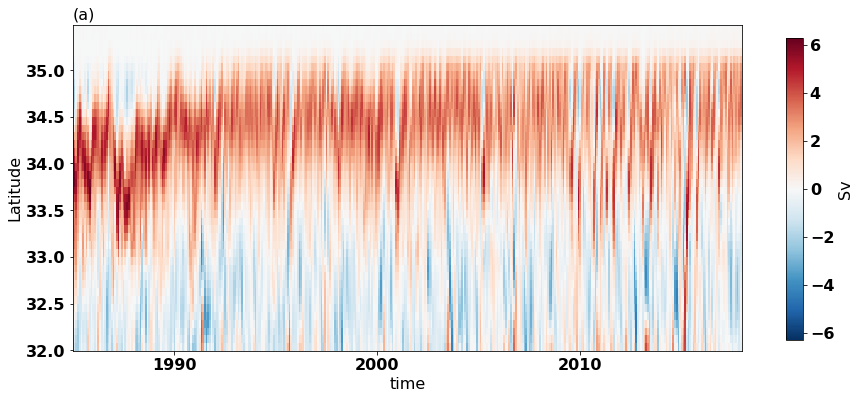

In [26]:
warnings.filterwarnings('ignore')
t=gs_trans.time.values
y=gs_trans.sel(yt_ocean=33,method='nearest').yt_ocean.values
fig=plt.figure(figsize=(12,6))
p1=gs_trans.plot(x='time',y='yt_ocean',add_colorbar=False)
#plt.plot(t,np.tile(y,len(t)),'k--')
#plt.title('Volume transport at 75$^{o}$W',fontsize=16)
plt.title('',fontsize=16)
plt.title('(a)',loc='left',fontsize=16)
plt.ylabel('Latitude')
cbar_ax=fig.add_axes([0.95,0.15,0.02,0.7])
cb=plt.colorbar(p1,cax=cbar_ax)
cb.ax.set_ylabel('Sv',fontsize=16)
#savefigure('gshvm')

In [18]:
gsp=gs_trans.sel(yt_ocean=slice(33,36)).sum('yt_ocean')
y=gsp.values
x=gsp.time.values
xnew=np.full(x.shape,np.nan)
for i in range(0,len(x)):
    xnew[i]=date.toordinal(date(x[i].year,x[i].month,x[i].day))
xnew1=xnew-xnew[0]
xnew2=xnew-np.mean(xnew)

In [42]:
res = stats.theilslopes(y,xnew1)#range(len(xnew)))
lsq_res = stats.linregress(xnew1, y)

In [43]:
ind=np.arange(0,396,32)
year=np.full(ind.shape,0)
for i in range(0,len(ind)):
    year[i]=date.fromordinal(xnew[ind[i]].astype(int)).year

10.554418598645304


Text(0,0.5,'transport (Sv)')

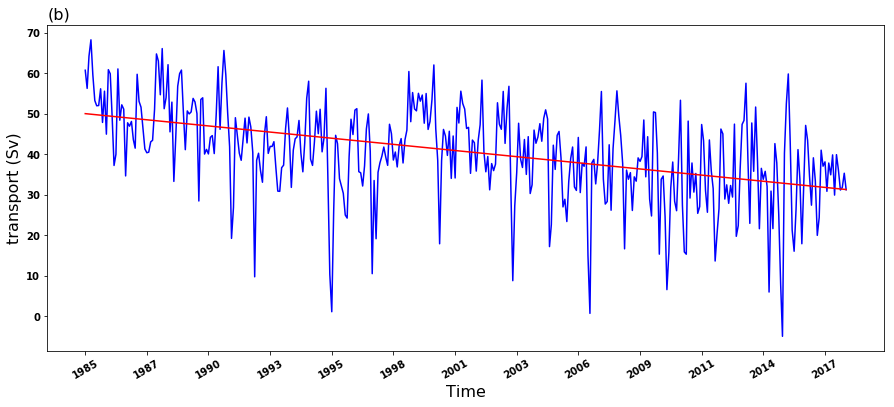

In [44]:
plt.figure(figsize=(15,6))
plt.plot(xnew1,y,'b')
plt.plot(xnew1,res[1]+(res[0]*xnew1),'r')
#plt.plot(xnew1,res[1]+(res[2]*xnew1),'r--')
#plt.plot(xnew1,res[1]+(res[3]*xnew1),'r--')
error=y-(res[1]+(res[0]*xnew1))
n_df=len(y)
std_error=np.sqrt((1/(n_df-2))*sum(error**2))
print(std_error)

var_t=sum((np.arange(n_df)-n_df/2)**2)
sb=std_error/np.sqrt(var_t)

#plt.plot(xnew,lsq_res[1]+lsq_res[0]*xnew,'g')
plt.xticks(xnew1[ind],year,rotation=30)
#plt.title('Volume transport',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.ylabel('transport (Sv)',fontsize=16)
#savefigure('theilsentrans')

### Gulf Stream transport (in comparison with Rossby etal 2014)

In [53]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
gs_trans = cc.querying.getvar(expt,'tx_trans',session,n=n,offset=offset)\
                               .sel(xu_ocean=-70,method='nearest')\
                               .sel(yt_ocean=slice(30,40))/1e6/1036
gs_trans_55=gs_trans.sel(st_ocean=55,method='nearest')

In [56]:
t=gs_trans_55.time.values
y1=gs_trans_55.sel(yt_ocean=33,method='nearest').yt_ocean.values
y2=gs_trans_55.sel(yt_ocean=37,method='nearest').yt_ocean.values
y3=gs_trans_55.sel(yt_ocean=36,method='nearest').yt_ocean.values
y4=gs_trans_55.sel(yt_ocean=39,method='nearest').yt_ocean.values

In [57]:
t1=gs_trans_55.sel(time=slice('1985-01-01','2002-01-01')).time.values
t2=gs_trans_55.sel(time=slice('2002-01-01','2018-01-01')).time.values

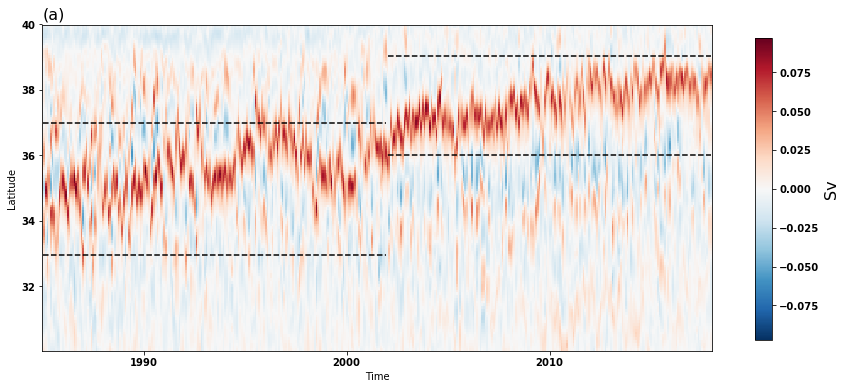

In [58]:
fig=plt.figure(figsize=(12,6))
p1=gs_trans_55.plot(x='time',y='yt_ocean',add_colorbar=False)
plt.plot(t1,np.tile(y1,len(t1)),'k--')
plt.plot(t1,np.tile(y2,len(t1)),'k--')
plt.plot(t2,np.tile(y3,len(t2)),'k--')
plt.plot(t2,np.tile(y4,len(t2)),'k--')
#plt.title('Transport at 55m')
plt.title('')
plt.title('(a)',loc='left',fontsize=16)
plt.xlabel('Time')
plt.ylabel('Latitude')
cbar_ax=fig.add_axes([0.95,0.15,0.02,0.7])
cb=plt.colorbar(p1,cax=cbar_ax)
cb.ax.set_ylabel('Sv',fontsize=16)
cb.formatter.set_powerlimits((0, 0))
#savefigure('Rossbytrans')

In [59]:
#layer thickness
z=gs_trans.st_ocean.values
w=cc.querying.getvar(expt,'wt',session,n=n,offset=offset)\
                                 .sel(xt_ocean=slice(-82, -62))\
                                 .sel(yt_ocean=slice(22,46))
zt=w.sw_ocean.values
b=gs_trans_55.st_ocean.values
ind2=np.where(z==b)[0][0]
dz2=zt[ind2]-zt[ind2-1]

Text(0.5,1,'')

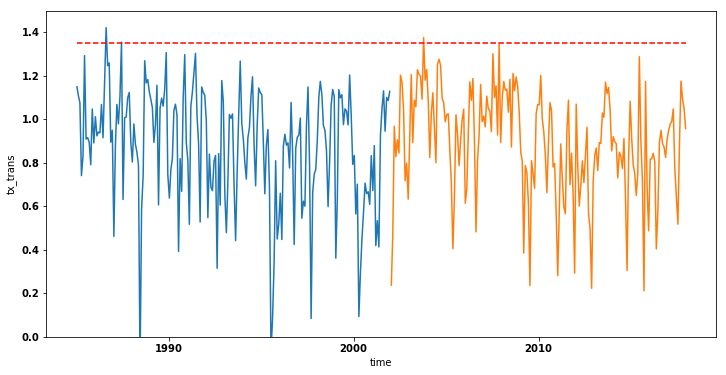

In [60]:
plt.figure(figsize=(12,6))
(gs_trans_55.sel(time=slice('1985-01-01','2002-01-01')).sel(yt_ocean=slice(33,37)).sum('yt_ocean')/dz2*10).plot()
(gs_trans_55.sel(time=slice('2002-01-01','2018-01-01')).sel(yt_ocean=slice(36,39)).sum('yt_ocean')/dz2*10).plot()
plt.plot(t,np.tile(1.35,len(t)),'r--')
plt.ylim([0,1.5])
plt.title('')

In [72]:
#positive only
g1=gs_trans_55.sel(time=slice('1985-01-01','2002-01-01')).sel(yt_ocean=slice(33,37)).values
g2=gs_trans_55.sel(time=slice('2002-01-01','2018-01-01')).sel(yt_ocean=slice(36,39)).values
g1[g1<0]=0
g2[g2<0]=0
g1_pos=xr.DataArray(g1,gs_trans_55.sel(time=slice('1985-01-01','2002-01-01')).sel(yt_ocean=slice(33,37)).coords)
g2_pos=xr.DataArray(g2,gs_trans_55.sel(time=slice('2002-01-01','2018-01-01')).sel(yt_ocean=slice(36,39)).coords)
mean1=(g1_pos.sum('yt_ocean')/dz2*10).mean('time').values
mean2=(g2_pos.sum('yt_ocean')/dz2*10).mean('time').values
print('Time-mean GS transport at 75W for the first stage is',mean1*10,'SV/m')
print('Time-mean GS transport at 75W for the first stage is',mean2*10,'Sv/m')

Time-mean GS transport at 75W for the first stage is 11.636220216751099 SV/m
Time-mean GS transport at 75W for the first stage is 10.270028114318848 Sv/m


In [67]:
#find the drop point in the last few years
#a=g2_pos.sel(time=slice('2008-01-01','2012-11-13')).sum('yt_ocean')/dz2*10
#amin=a.min().values
#a.where(a==amin,drop=True)
#(g2_pos.sel(time=slice('2011-01-14','2019-01-01')).sum('yt_ocean')/dz2*10).mean('time').values
#(g2_pos.sel(time=slice('2002-01-01','2011-01-13')).sum('yt_ocean')/dz2*10).mean('time').values
#x1=gs_trans_55.sel(time='1985-01-01',method='nearest').time.values
#x2=gs_trans_55.sel(time='2002-01-14',method='nearest').time.values
#x3=gs_trans_55.sel(time='2011-01-14',method='nearest').time.values
#x4=gs_trans_55.sel(time='2018-01-01',method='nearest').time.values
#y=np.arange(0.25,2.01,0.01)

Text(0,0.5,'layer transport (m$^{2}$s$^{-1}$)')

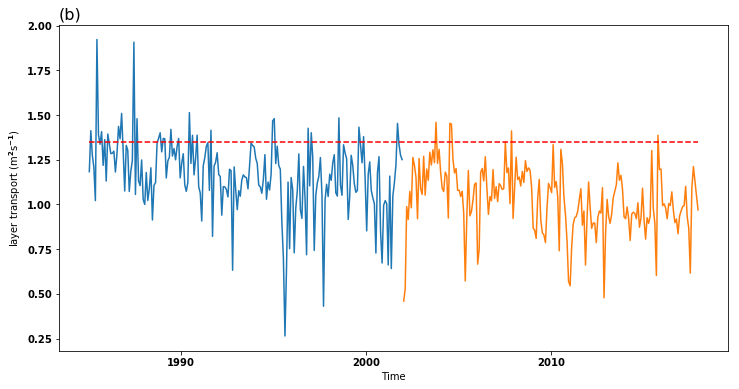

In [68]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,6))
(g1_pos.sum('yt_ocean')/dz2*10).plot()
(g2_pos.sum('yt_ocean')/dz2*10).plot()
plt.plot(t,np.tile(1.35,len(t)),'r--')
#plt.plot(np.tile(x1,len(y)),y,'k--')
#plt.plot(np.tile(x2,len(y)),y,'k--')
#plt.plot(np.tile(x3,len(y)),y,'k--')
#plt.plot(np.tile(x4,len(y)),y,'k--')
#plt.title('Transport at 55m',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=16)
plt.xlabel('Time')
plt.ylabel('layer transport (m$^{2}$s$^{-1}$)')
#savefigure('tstrans55')

### for location

In [76]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
u = cc.querying.getvar(expt,'u',session,
                                n=n,offset=offset)\
                               .sel(xu_ocean=slice(-90, 0))\
                               .sel(yu_ocean=slice(0,70))
v = cc.querying.getvar(expt,'v',session,
                                n=n,offset=offset)\
                               .sel(xu_ocean=slice(-90, 0))\
                               .sel(yu_ocean=slice(0,70))

In [77]:
speed=np.sqrt(u.sel(st_ocean=0,method='nearest')**2+v.sel(st_ocean=0,method='nearest')**2)
speed_tm=speed.sel(time=slice('1985-01-01','1986-01-01')).mean('time')
x1=speed_tm.sel(xu_ocean=-75,method='nearest').xu_ocean.values
x2=speed_tm.sel(xu_ocean=-70,method='nearest').xu_ocean.values
y1=speed_tm.sel(yu_ocean=27,method='nearest').yu_ocean.values
y2=speed_tm.sel(yu_ocean=45,method='nearest').yu_ocean.values
y=speed_tm.yu_ocean.values
x=speed_tm.xu_ocean.values

Text(0,0.5,'Latitude')

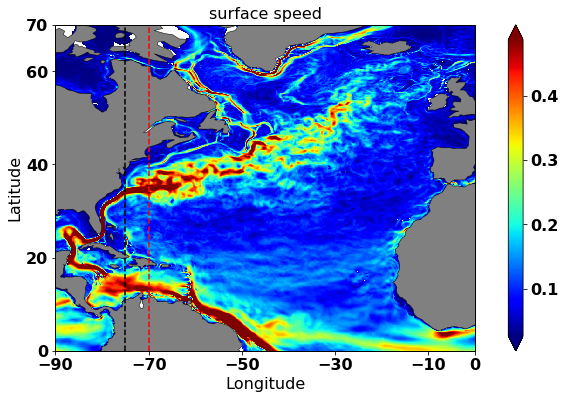

In [96]:
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent([-90,0,0,70],crs=ccrs.PlateCarree())
ax.set_xticks([-90,-70,-50,-30,-10,0],crs=ccrs.PlateCarree())
ax.set_yticks([0,20,40,60,70],crs=ccrs.PlateCarree())
speed_tm.plot(cmap='jet',robust=True)
plt.plot(np.tile(x1,len(y)),y,'k--')
plt.plot(np.tile(x2,len(y)),y,'r--')
#plt.plot(x,np.tile(y1,len(x)),'k--')
#plt.plot(x,np.tile(y2,len(x)),'k--')
plt.title('surface speed',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
#savefigure('loc4')

### Gulf Stream transport (in comparison with Rossby etal 2014) new run

In [74]:
warnings.filterwarnings('ignore')
expt='01deg_jra55v13_ryf9091'
gs_trans = cc.querying.getvar(expt,'tx_trans',session)\
                               .sel(xu_ocean=-70,method='nearest')\
                               .sel(yt_ocean=slice(30,40))/1e6/1036

In [91]:
t=gs_trans.time.values
gs_trans_55=gs_trans.sel(st_ocean=55,method='nearest')
y1=gs_trans.sel(yt_ocean=36.5,method='nearest').yt_ocean.values
y2=gs_trans.sel(yt_ocean=39,method='nearest').yt_ocean.values
y3=gs_trans.sel(yt_ocean=34.5,method='nearest').yt_ocean.values
y4=gs_trans.sel(yt_ocean=38,method='nearest').yt_ocean.values
t1=gs_trans_55.sel(time=slice('1900-01-01','1903-09-01')).time.values
t2=gs_trans_55.sel(time=slice('1903-09-01','1944-03-01')).time.values

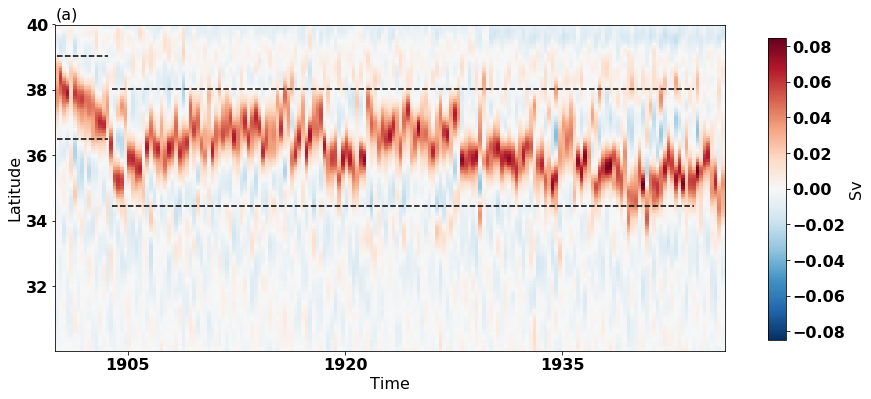

In [89]:
fig=plt.figure(figsize=(12,6))
p1=gs_trans_55.plot(x='time',y='yt_ocean',add_colorbar=False)
plt.plot(t1,np.tile(y1,len(t1)),'k--')
plt.plot(t1,np.tile(y2,len(t1)),'k--')
plt.plot(t2,np.tile(y3,len(t2)),'k--')
plt.plot(t2,np.tile(y4,len(t2)),'k--')
#plt.title('Transport at 55m')
plt.title('')
plt.title('(a)',loc='left',fontsize=16)
plt.xlabel('Time')
plt.ylabel('Latitude')
cbar_ax=fig.add_axes([0.95,0.15,0.02,0.7])
cb=plt.colorbar(p1,cax=cbar_ax)
cb.ax.set_ylabel('Sv',fontsize=16)
cb.formatter.set_powerlimits((0, 0))

Text(0.5,1,'')

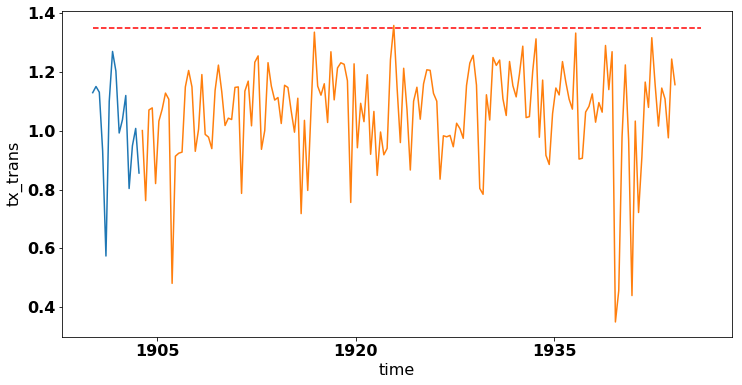

In [92]:
plt.figure(figsize=(12,6))
(gs_trans_55.sel(time=slice('1900-01-01','1903-09-01')).sel(yt_ocean=slice(y1,y2)).sum('yt_ocean')/dz2*10).plot()
(gs_trans_55.sel(time=slice('1903-09-01','1944-03-01')).sel(yt_ocean=slice(y3,y4)).sum('yt_ocean')/dz2*10).plot()
plt.plot(t,np.tile(1.35,len(t)),'r--')
plt.title('')

In [94]:
# positive only
g1=gs_trans_55.sel(time=slice('1900-01-01','1903-09-01')).sel(yt_ocean=slice(y1,y2)).values
g2=gs_trans_55.sel(time=slice('1903-09-01','1944-03-01')).sel(yt_ocean=slice(y3,y4)).values
g1[g1<0]=0
g2[g2<0]=0
g1_pos=xr.DataArray(g1,gs_trans_55.sel(time=slice('1900-01-01','1903-09-01')).sel(yt_ocean=slice(y1,y2)).coords)
g2_pos=xr.DataArray(g2,gs_trans_55.sel(time=slice('1903-09-01','1944-03-01')).sel(yt_ocean=slice(y3,y4)).coords)

Time-mean GS transport at 75W for the first stage is 10.817550420761108 SV/m
Time-mean GS transport at 75W for the first stage is 12.030932903289795 Sv/m


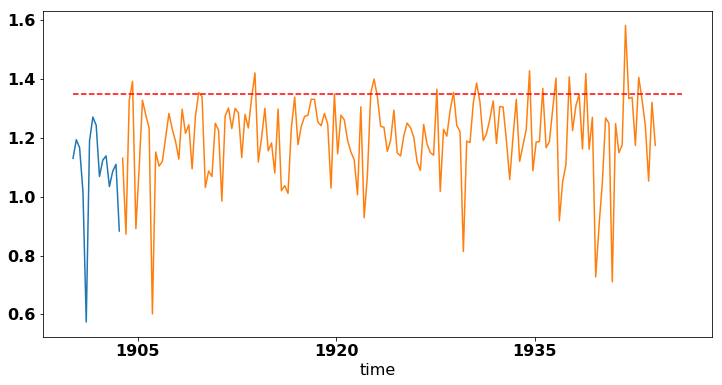

In [97]:
plt.figure(figsize=(12,6))
(g1_pos.sum('yt_ocean')/dz2*10).plot()
(g2_pos.sum('yt_ocean')/dz2*10).plot()
plt.plot(t,np.tile(1.35,len(t)),'r--')
plt.title('')
mean1=(g1_pos.sum('yt_ocean')/dz2*10).mean().values
mean2=(g2_pos.sum('yt_ocean')/dz2*10).mean().values
print('Time-mean GS transport at 75W for the first stage is',mean1*10,'SV/m')
print('Time-mean GS transport at 75W for the first stage is',mean2*10,'Sv/m')

## Florida Current transport

In [130]:
def trans_prof(ekey):
    expt=exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    transport = cc.querying.getvar(expt,'ty_trans_int_z',session,
                                   n=n,offset=offset)\
                                   .sel(xt_ocean=slice(-81,-78.5))\
                                   .sel(yu_ocean=27,method='nearest')/1e6/1036
    return transport

In [123]:
grid1=xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_A/output012/ocean/ocean_grid.nc')
grid025=xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output045/ocean/ocean_grid.nc')
grid01 = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')

gridx=np.empty((4,1))
gridx[0]=grid1.dxt.sel(yt_ocean=27,method='nearest').sel(xt_ocean=slice(-85,-70)).values[1]
gridx[1]=grid025.dxt.sel(yt_ocean=27,method='nearest').sel(xt_ocean=slice(-85,-70)).values[1]
gridx[2]=grid025.dxt.sel(yt_ocean=27,method='nearest').sel(xt_ocean=slice(-85,-70)).values[1]
gridx[3]=grid01.dxt.sel(yt_ocean=27,method='nearest').sel(xt_ocean=slice(-85,-70)).values[1]

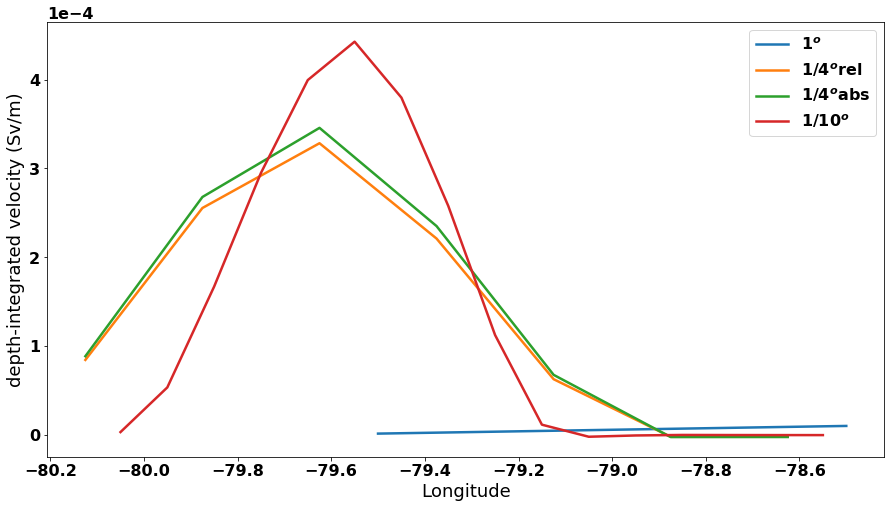

In [131]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(15,8))
for i,ekey in enumerate(exptdata.exptdict.keys()):
    trans=trans_prof(ekey).mean('time')
    plt.plot(trans['xt_ocean'],trans.values/gridx[i],linewidth=2.5)
plt.legend(['1$^{o}$','1/4$^{o}$rel','1/4$^{o}$abs','1/10$^{o}$'])
ax = plt.gca() 
ax.ticklabel_format(style='sci', axis='y') 
ax.yaxis.major.formatter.set_powerlimits((0,0)) 
plt.ylabel('depth-integrated velocity (Sv/m)',fontsize=18)
plt.xlabel('Longitude',fontsize=18)
savefigure('transflorida')

In [136]:
#time series in ACCESS-OM2-01
transport_fc=trans_prof('01deg').sum('xt_ocean')
x=transport_fc.time.values
y=transport_fc.values
xnew=np.full(x.shape,np.nan)
for i in range(0,len(x)):
    xnew[i]=date.toordinal(date(x[i].year,x[i].month,x[i].day))
xnew1=xnew-xnew[0]
xnew2=xnew-np.mean(xnew)
res = stats.theilslopes(y,xnew1)

In [137]:
ind=np.arange(0,396,32)
year=np.full(ind.shape,0)
for i in range(0,len(ind)):
    year[i]=date.fromordinal(xnew[ind[i]].astype(int)).year

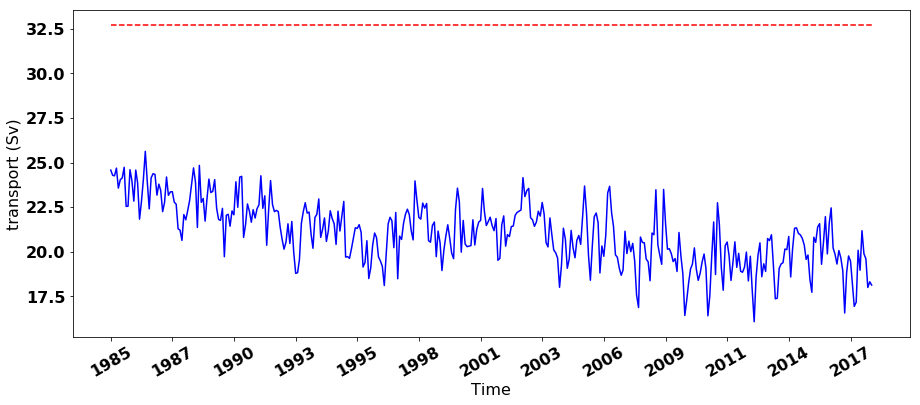

In [141]:
plt.figure(figsize=(15,6))
plt.plot(xnew1,y,'b')
plt.plot(xnew1,np.tile(32.7,len(xnew1)),'r--')
#plt.plot(xnew1,res[1]+(res[0]*xnew1),'r')
#plt.plot(xnew1,res[1]+(res[2]*xnew1),'r--')
#plt.plot(xnew1,res[1]+(res[3]*xnew1),'r--')
error=y-(res[1]+(res[0]*xnew1))
n_df=len(y)
std_error=np.sqrt((1/(n_df-2))*sum(error**2))
#print(std_error)

var_t=sum((np.arange(n_df)-n_df/2)**2)
sb=std_error/np.sqrt(var_t)

#plt.plot(xnew,lsq_res[1]+lsq_res[0]*xnew,'g')
plt.xticks(xnew1[ind],year,rotation=30)
plt.title('')
#plt.title('(b)',loc='left',fontsize=16)
#plt.title('Volume transport',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.ylabel('transport (Sv)',fontsize=16)
savefigure('obs_fc')
#savefigure('theilsentrans_fc')

## Kuroshio transport

In [103]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
kc_trans = cc.querying.getvar(expt,'tx_trans',session,n=n,offset=offset)\
                               .sel(xu_ocean=slice(120-360,155-360))\
                               .sel(yt_ocean=slice(23,45))/1e6/1036

In [106]:
#transect location
warnings.filterwarnings('ignore')
x=kc_trans.sum('st_ocean').sel(xu_ocean=134-360,method='nearest').xu_ocean.values
y=kc_trans.sum('st_ocean').yt_ocean.values

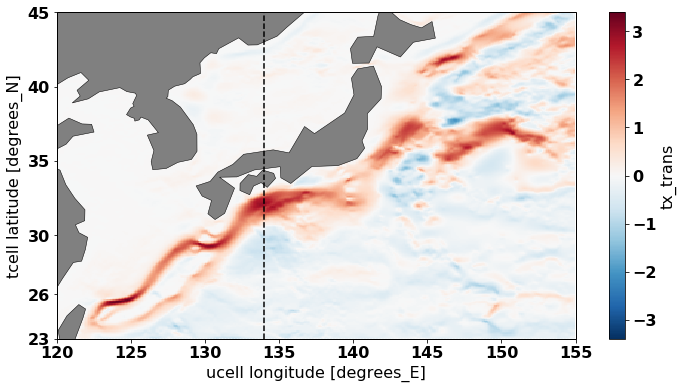

In [112]:
fig=plt.figure(figsize=(12,6))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent([120-360,155-360, 23,45], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([120,125,130,135,140,145,150,155], crs=ccrs.PlateCarree())
ax0.set_yticks([23,26,30,35,40,45], crs=ccrs.PlateCarree())
kc_trans.sum('st_ocean').mean('time').plot()
plt.plot(np.tile(x+360,len(y)),y,'k--')

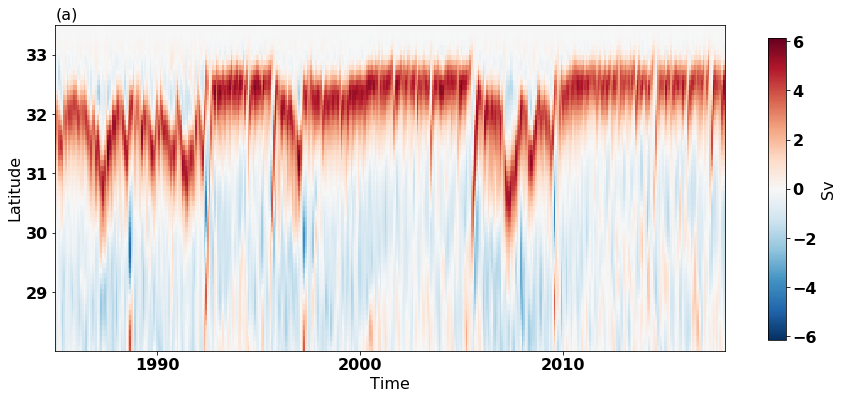

In [113]:
y1=kc_trans.sel(yt_ocean=30,method='nearest').yt_ocean.values
fig=plt.figure(figsize=(12,6))
p1=kc_trans.sel(st_ocean=slice(0,1000)).sel(xu_ocean=134-360,method='nearest')\
        .sum('st_ocean').sel(yt_ocean=slice(28,33.5)).plot(x='time',y='yt_ocean',add_colorbar=False)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=16)
cbar_ax=fig.add_axes([0.95,0.15,0.02,0.7])
cb=plt.colorbar(p1,cax=cbar_ax)
cb.ax.set_ylabel('Sv',fontsize=16)
savefigure('kc_trans')

In [115]:
kc_trans_sel=kc_trans.sel(st_ocean=slice(0,1000)).sel(xu_ocean=134-360,method='nearest').sum('st_ocean').sel(yt_ocean=slice(30,33))
g=kc_trans_sel.values
g[g<0]=0
gpos=xr.DataArray(g,coords=kc_trans_sel.coords)
gpos.sel(time=slice('1992-01-01','2000-01-01')).sum('yt_ocean').mean('time').values
meankc=gpos.sum('yt_ocean').mean('time').values
print('time-mean KC transport at 134E is',meankc,'Sv')

time-mean KC transport at 134E is 50.003826 Sv


Text(0,0.5,'transport(Sv)')

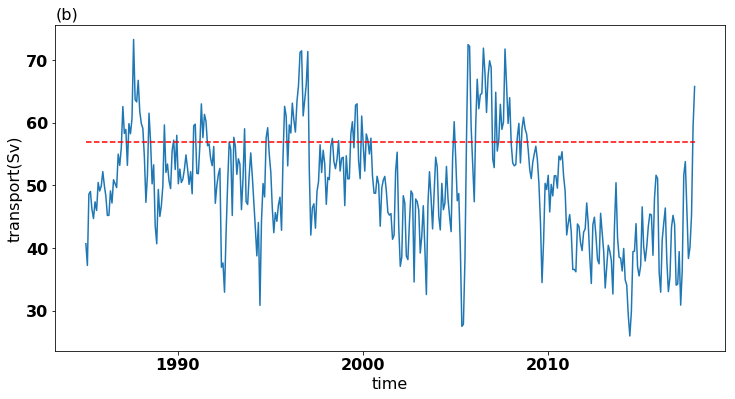

In [120]:
x=gpos.time.values
fig=plt.figure(figsize=(12,6))
gpos.sum('yt_ocean').plot()
plt.plot(x,np.tile(57,len(x)),'r--')
plt.title('')
plt.title('(b)',loc='left',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.ylabel('transport(Sv)',fontsize=16)
#savefigure('kc_trans_ts')